In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wednesday May 10 10:11:42 2023
Example Code for optimizing spiral trajectory jointly with Image Deep Artifact Suppression network (FastDVDnet) for interactive MRI

Methods details in : 
HyperSLICE: HyperBand optimised Spiral for Low-latency Interactive Cardiac Examination, (2023)

Trained from flower image dataset.
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

@author: Dr. Olivier Jaubert
"""

import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import numpy as np
import tensorflow as tf
try:
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('running on CPU')
import tensorflow_mri as tfmri
import random
import matplotlib.pyplot as plt
import datetime
import pathlib
import keras_tuner as kt

import model.hypermodel as hypermodel
# Local imports (works if you are in project folder)
import model.layers as layers
import utils.preprocessing_natural_images as preproc_filename_2_kspace
import utils.preprocessing_trajectory_gen as preproc_traj
import utils.preprocessing_fastdvdnet_noselect as preproc_fastdvdnet
import utils.preprocessing_rolling_fastdvdnet as preproc_roll
import utils.display_function_fastdvdnet as display_func


#Set seed for all packages
seed_value=1
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
;

2023-11-21 16:19:59.989636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-21 16:20:00.026736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-21 16:20:00.026859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-21 16:20:02.656819: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

''

In [7]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

In [8]:
#Configuration
DEBUG=True
learning_rate=0.0001

config_traj=preproc_traj.config_optimized_traj()
config_preproc=preproc_fastdvdnet.config_base_preproc()
config_natural_images={'base_resolution':config_preproc['base_resolution'],'phases':config_preproc['phases'],'num_coils':10,'addmotion':1}

config={'experiment_path': 'HyperBand_folder',
        'experiment_name': 'Test_FastDVDnet',
        'split' : [0.7,0.15,0.15], #train, val, test
        'split_mode': 'noshuffle', #noshuffle or random
        'learning_rate': learning_rate,
        'optimizer': tf.keras.optimizers.Adam(learning_rate=learning_rate,clipnorm=1),
        'epochs':200,
        'loss': tfmri.losses.StructuralSimilarityLoss(rank=2),
        'metrics':[tfmri.metrics.PeakSignalToNoiseRatio(rank=2),
                   tfmri.metrics.StructuralSimilarity(rank=2)]}

imshape=(config_preproc['phases'],config_preproc['base_resolution'],config_preproc['base_resolution'])

config_model={'scales': 3,
      'block_depth': 2,
      'base_filters': 32,
      'kernel_size': 3,
      'use_deconv': 'PixelShuffle',
      'rank': 2,
      'activation': tf.keras.activations.relu,
      'out_channels': 1,
      'kernel_initializer': tf.keras.initializers.HeUniform(seed=1),
      'time_distributed': False}

In [9]:
# Read files and split data 
train_files=[]
val_files=[]
test_files=[]
sorted_files=[x for x in sorted(list(map(str,data_dir.glob('roses/*'))))]
if DEBUG:
      n=20
else:
      n=len(sorted_files); 
ntrain=int(config['split'][0]*n); nval=int(config['split'][1]*n); ntest=int(np.ceil(config['split'][2]*n))

train_files=sorted_files[:ntrain]
val_files=sorted_files[ntrain:ntrain+nval]
test_files=sorted_files[ntrain+nval:ntrain+nval+ntest]

# Shuffle files.
random.shuffle(train_files)
random.shuffle(val_files)
random.shuffle(test_files)

print('Total/Train/Val/Test:',len(train_files)+len(val_files)+len(test_files),
      '/',len(train_files),'/',len(val_files),'/',len(test_files),'leftovers:',n-ntrain-nval-ntest)

Total/Train/Val/Test: 20 / 14 / 3 / 3 leftovers: 0


(-0.5, 1439.5, 239.5, -0.5)

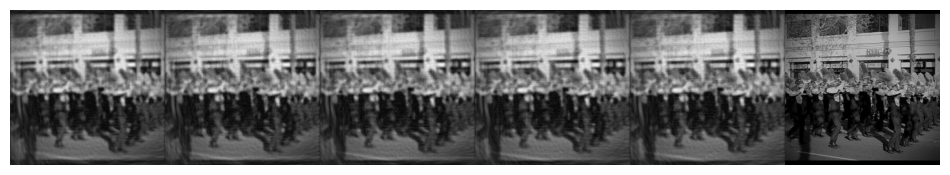

In [10]:
#Define Preprocessing run once to get input shapes
preproc_natural_image=preproc_filename_2_kspace.preprocessing_fn(**config_natural_images)
traj_function=preproc_traj.create_traj_fn(**config_traj)
preproc_function=preproc_fastdvdnet.preprocessing_fn(**config_preproc)
roll_function=preproc_roll.preprocessing_fn()
# Run Preprocessing once on case [0]
kspace=preproc_natural_image(train_files[1])
ds=tf.data.Dataset.from_tensors(kspace)
image=traj_function(ds)
for element in image:
  inputs_temp,gt_temp=preproc_function(element)
  inputs,gt=roll_function(inputs_temp,gt_temp)
plt.figure(figsize=(12,3))
plt.imshow(np.abs(np.concatenate((inputs[:,:,0],inputs[:,:,1],inputs[:,:,2],inputs[:,:,3],inputs[:,:,4],gt[:,:,0]),axis=1)),cmap='gray')
plt.axis('off')

In [11]:
#Creating Tensorflow dataset
# Create datasets.
datasets=[train_files,val_files,test_files]
prepdatasets=[]
for pp,dataset in enumerate(datasets):
    dataset = tf.data.Dataset.from_tensor_slices(
        tf.convert_to_tensor(list(map(str, dataset)), dtype=tf.string))
    dataset=dataset.map(preproc_natural_image,num_parallel_calls=1)
    prepdatasets.append(dataset)

In [12]:
#Define hyperparameter ranges for optimization
config_traj['ordering']=['tiny','linear']
config_traj['vd_spiral_arms']=[12,24]
config_traj['vd_inner_cutoff']=[0.1,0.4]
config_traj['pre_vd_outer_cutoff']=[0.01,1.0]
config_traj['vd_outer_density']=[0.01,0.35]
config_traj['vd_type']=['linear','hanning','quadratic']

In [13]:
#HyperModel FastDVDnet
config_traj_hp=config_traj
hpmodel=hypermodel.HyperModelFastDVDnet(config_model,
                    inputs.shape,
                    optimizer=config['optimizer'],
                    loss=config['loss'],
                    metrics=config['metrics'],name='HM', tunable=True)

#Define Hyperparameters outside for HyperBand
hp = kt.HyperParameters()
hp.Choice('ordering',config_traj['ordering'])
hp.Int('vd_spiral_arms',config_traj['vd_spiral_arms'][0],config_traj['vd_spiral_arms'][1])
hp.Float('vdi',config_traj['vd_inner_cutoff'][0],config_traj['vd_inner_cutoff'][1])
hp.Float('pre_vdo',config_traj['pre_vd_outer_cutoff'][0],config_traj['pre_vd_outer_cutoff'][1])
hp.Float('outer_den',config_traj['vd_outer_density'][0],config_traj['vd_outer_density'][1])
hp.Choice('vd_type',['linear','hanning','quadratic'])

if DEBUG:
    max_epochs=5
    tuner = kt.Hyperband(
        hypermodel=hpmodel,
        objective=kt.Objective('val_loss', "min"),
        max_epochs=max_epochs,
        factor=3,
        hyperband_iterations=1,
        directory="results",
        project_name="debug_hyperband",
        overwrite=True,
        seed=0,
        hyperparameters=hp,
    )
else:
    max_epochs=150
    tuner = kt.Hyperband(
        objective=kt.Objective('val_loss', "min"),
        factor=5,
        hyperband_iterations=1,
        max_epochs=max_epochs,
        hypermodel=hpmodel,
        directory="results",
        project_name="hyperband",
        overwrite=True,
        hyperparameters=hp,
        seed=0,
    )


In [14]:
#Launch HyperParameter optimisation
callbacks=[]
tuner.search(prepdatasets,config_preproc,config_traj,callbacks=callbacks)


Trial 2 Complete [00h 00m 10s]
val_loss: 0.863966166973114

Best val_loss So Far: 0.6242018342018127
Total elapsed time: 00h 00m 33s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
linear            |linear            |ordering
15                |22                |vd_spiral_arms
0.16093           |0.3465            |vdi
0.24816           |0.51309           |pre_vdo
0.34436           |0.052659          |outer_den
linear            |hanning           |vd_type
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
1                 |1                 |tuner/bracket
0                 |0                 |tuner/round

Traj params pre: {'ordering': 'linear', 'vd_spiral_arms': 15, 'vdi': 0.1609285075035447, 'pre_vdo': 0.24816106621185358, 'outer_den': 0.34435922855938356, 'vd_type': 'linear', 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
Traj params post: {'flow': 0, 'bas

KeyboardInterrupt: 

In [ ]:
#Retrain Best model
hpmodel=hypermodel.HyperModelFastDVDnet(config_model,
                    inputs.shape,
                    optimizer=config['optimizer'],
                    loss=config['loss'],
                    metrics=config['metrics'],name='HM', tunable=True)
                    
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()
best_model = tuner.load_model(best_trial)

path = config['experiment_path']
exp_name = os.path.splitext(os.path.basename(config['experiment_name']))[0]
exp_name += '_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
exp_dir = os.path.join(path, exp_name)

print(exp_dir)
callbacks=[]
checkpoint_filepath=os.path.join(exp_dir,'ckpt/saved_model')
callbacks.append(tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        mode='min',
        save_weights_only=False,
        save_best_only=True))
callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=os.path.join(exp_dir,'logs')))

print(best_hps.values)
model = tuner.hypermodel.build(best_hps)
model.summary()
history = hpmodel.fit(best_hps,best_model, prepdatasets,config_preproc,config_traj,callbacks=callbacks,epochs=np.max((50,max_epochs)))

Trial 0005 summary
Hyperparameters:
ordering: linear
vd_spiral_arms: 21
vdi: 0.37020291267180283
pre_vdo: 0.3371587993577936
outer_den: 0.1409644650670577
vd_type: quadratic
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0004
Score: 0.23394757509231567
HyperBand_folder/Test_FastDVDnet_20231117_161332
{'ordering': 'linear', 'vd_spiral_arms': 21, 'vdi': 0.37020291267180283, 'pre_vdo': 0.3371587993577936, 'outer_den': 0.1409644650670577, 'vd_type': 'quadratic', 'tuner/epochs': 5, 'tuner/initial_epoch': 2, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0004'}
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 5)]     0         
                                                                 
 fast_dvd_net_1 (FastDVDNet)  (None, 240, 240, 1)      1589506   
                                         

INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


14/14 [==============================] - 9s 585ms/step - loss: 0.3038 - psnr: 19.0614 - ssim: 0.6300 - val_loss: 0.2424 - val_psnr: 23.0573 - val_ssim: 0.7576
Epoch 2/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2996 - psnr: 22.3013 - ssim: 0.7004WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f778c045430>, because it is not built.


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


14/14 [==============================] - 3s 236ms/step - loss: 0.2953 - psnr: 22.3157 - ssim: 0.7047 - val_loss: 0.2254 - val_psnr: 23.9345 - val_ssim: 0.7746
Epoch 3/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2887 - psnr: 22.6638 - ssim: 0.7113WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f778c045430>, because it is not built.


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


14/14 [==============================] - 3s 227ms/step - loss: 0.2880 - psnr: 22.5505 - ssim: 0.7120 - val_loss: 0.2075 - val_psnr: 24.9562 - val_ssim: 0.7925
Epoch 4/50
13/14 [==========================>...] - ETA: 0s - loss: 0.3010 - psnr: 23.4271 - ssim: 0.6990WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f778c045430>, because it is not built.


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


14/14 [==============================] - 3s 247ms/step - loss: 0.2986 - psnr: 23.2490 - ssim: 0.7014 - val_loss: 0.1984 - val_psnr: 24.6393 - val_ssim: 0.8016
Epoch 5/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2790 - psnr: 23.1356 - ssim: 0.7210WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f778c045430>, because it is not built.


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


14/14 [==============================] - 3s 237ms/step - loss: 0.2755 - psnr: 23.0650 - ssim: 0.7245 - val_loss: 0.1912 - val_psnr: 25.2155 - val_ssim: 0.8088
Epoch 6/50
14/14 [==============================] - 1s 74ms/step - loss: 0.2635 - psnr: 23.4885 - ssim: 0.7365 - val_loss: 0.1964 - val_psnr: 24.3757 - val_ssim: 0.8036
Epoch 7/50
14/14 [==============================] - ETA: 0s - loss: 0.2648 - psnr: 23.8495 - ssim: 0.7352WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f778c045430>, because it is not built.


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


14/14 [==============================] - 3s 220ms/step - loss: 0.2648 - psnr: 23.8495 - ssim: 0.7352 - val_loss: 0.1877 - val_psnr: 24.7901 - val_ssim: 0.8123
Epoch 8/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2437 - psnr: 24.0264 - ssim: 0.7563WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f778c045430>, because it is not built.


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


14/14 [==============================] - 3s 241ms/step - loss: 0.2399 - psnr: 24.0223 - ssim: 0.7601 - val_loss: 0.1817 - val_psnr: 25.3223 - val_ssim: 0.8183
Epoch 9/50
14/14 [==============================] - 1s 69ms/step - loss: 0.2637 - psnr: 23.8120 - ssim: 0.7363 - val_loss: 0.1819 - val_psnr: 25.2343 - val_ssim: 0.8181
Epoch 10/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2501 - psnr: 22.8255 - ssim: 0.7499WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f778c045430>, because it is not built.


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


14/14 [==============================] - 3s 234ms/step - loss: 0.2470 - psnr: 22.8475 - ssim: 0.7530 - val_loss: 0.1814 - val_psnr: 24.4805 - val_ssim: 0.8186
Epoch 11/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2625 - psnr: 22.7773 - ssim: 0.7375WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f778c045430>, because it is not built.


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


14/14 [==============================] - 3s 221ms/step - loss: 0.2569 - psnr: 22.8798 - ssim: 0.7431 - val_loss: 0.1764 - val_psnr: 25.1971 - val_ssim: 0.8236
Epoch 12/50
14/14 [==============================] - 1s 72ms/step - loss: 0.2316 - psnr: 24.5968 - ssim: 0.7684 - val_loss: 0.1772 - val_psnr: 25.6681 - val_ssim: 0.8228
Epoch 13/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2583 - psnr: 24.1005 - ssim: 0.7417WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f778c045430>, because it is not built.


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


14/14 [==============================] - 3s 236ms/step - loss: 0.2557 - psnr: 24.0092 - ssim: 0.7443 - val_loss: 0.1696 - val_psnr: 26.0088 - val_ssim: 0.8304
Epoch 14/50
14/14 [==============================] - 1s 72ms/step - loss: 0.2546 - psnr: 23.9988 - ssim: 0.7454 - val_loss: 0.1710 - val_psnr: 25.4787 - val_ssim: 0.8290
Epoch 15/50
14/14 [==============================] - 1s 70ms/step - loss: 0.2205 - psnr: 24.5947 - ssim: 0.7795 - val_loss: 0.1772 - val_psnr: 25.0113 - val_ssim: 0.8228
Epoch 16/50
14/14 [==============================] - 1s 74ms/step - loss: 0.2442 - psnr: 23.2052 - ssim: 0.7558 - val_loss: 0.1741 - val_psnr: 25.3560 - val_ssim: 0.8259
Epoch 17/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2431 - psnr: 23.7976 - ssim: 0.7569WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f778c045430>, because it is not built.


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


14/14 [==============================] - 3s 232ms/step - loss: 0.2383 - psnr: 23.8418 - ssim: 0.7617 - val_loss: 0.1660 - val_psnr: 25.4091 - val_ssim: 0.8340
Epoch 18/50
14/14 [==============================] - 1s 77ms/step - loss: 0.2509 - psnr: 24.0150 - ssim: 0.7491 - val_loss: 0.1853 - val_psnr: 23.7893 - val_ssim: 0.8147
Epoch 19/50
14/14 [==============================] - 1s 74ms/step - loss: 0.2628 - psnr: 22.3143 - ssim: 0.7372 - val_loss: 0.1928 - val_psnr: 22.4443 - val_ssim: 0.8072
Epoch 20/50
14/14 [==============================] - 1s 75ms/step - loss: 0.2338 - psnr: 22.7240 - ssim: 0.7662 - val_loss: 0.1665 - val_psnr: 25.8667 - val_ssim: 0.8335
Epoch 21/50
14/14 [==============================] - 1s 75ms/step - loss: 0.2335 - psnr: 24.2057 - ssim: 0.7665 - val_loss: 0.1663 - val_psnr: 25.4812 - val_ssim: 0.8337
Epoch 22/50
14/14 [==============================] - 1s 75ms/step - loss: 0.2188 - psnr: 24.6563 - ssim: 0.7812 - val_loss: 0.1670 - val_psnr: 25.8676 - val_ssim

INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


14/14 [==============================] - 3s 222ms/step - loss: 0.2214 - psnr: 24.4687 - ssim: 0.7786 - val_loss: 0.1642 - val_psnr: 25.7783 - val_ssim: 0.8358
Epoch 24/50
14/14 [==============================] - 1s 72ms/step - loss: 0.2128 - psnr: 24.9586 - ssim: 0.7872 - val_loss: 0.1665 - val_psnr: 25.0872 - val_ssim: 0.8335
Epoch 25/50
14/14 [==============================] - 1s 71ms/step - loss: 0.2178 - psnr: 23.8745 - ssim: 0.7822 - val_loss: 0.1871 - val_psnr: 22.2156 - val_ssim: 0.8129
Epoch 26/50
14/14 [==============================] - 1s 72ms/step - loss: 0.2316 - psnr: 22.7357 - ssim: 0.7684 - val_loss: 0.1712 - val_psnr: 23.2467 - val_ssim: 0.8288
Epoch 27/50
14/14 [==============================] - 1s 71ms/step - loss: 0.2673 - psnr: 23.1634 - ssim: 0.7327 - val_loss: 0.1674 - val_psnr: 24.0582 - val_ssim: 0.8326
Epoch 28/50
14/14 [==============================] - 1s 72ms/step - loss: 0.2248 - psnr: 24.4256 - ssim: 0.7752 - val_loss: 0.1652 - val_psnr: 25.8796 - val_ssim

INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


14/14 [==============================] - 3s 244ms/step - loss: 0.2352 - psnr: 24.0868 - ssim: 0.7648 - val_loss: 0.1605 - val_psnr: 26.2662 - val_ssim: 0.8395
Epoch 30/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2188 - psnr: 24.6937 - ssim: 0.7812WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f778c045430>, because it is not built.


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


14/14 [==============================] - 3s 243ms/step - loss: 0.2314 - psnr: 24.2984 - ssim: 0.7686 - val_loss: 0.1587 - val_psnr: 26.1455 - val_ssim: 0.8413
Epoch 31/50
14/14 [==============================] - 1s 76ms/step - loss: 0.2001 - psnr: 25.3881 - ssim: 0.7999 - val_loss: 0.1632 - val_psnr: 25.7391 - val_ssim: 0.8368
Epoch 32/50
14/14 [==============================] - 1s 78ms/step - loss: 0.2341 - psnr: 24.5019 - ssim: 0.7659 - val_loss: 0.1667 - val_psnr: 26.1908 - val_ssim: 0.8333
Epoch 33/50
14/14 [==============================] - 1s 74ms/step - loss: 0.2048 - psnr: 25.0204 - ssim: 0.7952 - val_loss: 0.1643 - val_psnr: 25.2337 - val_ssim: 0.8357
Epoch 34/50
14/14 [==============================] - 1s 75ms/step - loss: 0.2472 - psnr: 23.7444 - ssim: 0.7528 - val_loss: 0.1702 - val_psnr: 22.7669 - val_ssim: 0.8298
Epoch 35/50
14/14 [==============================] - 1s 78ms/step - loss: 0.1994 - psnr: 24.7689 - ssim: 0.8006 - val_loss: 0.1622 - val_psnr: 26.3487 - val_ssim

INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


14/14 [==============================] - 3s 227ms/step - loss: 0.2240 - psnr: 24.1482 - ssim: 0.7760 - val_loss: 0.1563 - val_psnr: 26.2224 - val_ssim: 0.8437
Epoch 39/50
14/14 [==============================] - 1s 71ms/step - loss: 0.2114 - psnr: 24.7200 - ssim: 0.7886 - val_loss: 0.1633 - val_psnr: 25.2495 - val_ssim: 0.8367
Epoch 40/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2113 - psnr: 24.8401 - ssim: 0.7887WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f778c045430>, because it is not built.


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231117_161332/ckpt/saved_model/assets


14/14 [==============================] - 3s 242ms/step - loss: 0.2065 - psnr: 24.8690 - ssim: 0.7935 - val_loss: 0.1559 - val_psnr: 25.8702 - val_ssim: 0.8441
Epoch 41/50
14/14 [==============================] - 1s 71ms/step - loss: 0.2028 - psnr: 25.0294 - ssim: 0.7972 - val_loss: 0.1608 - val_psnr: 26.1485 - val_ssim: 0.8392
Epoch 42/50
14/14 [==============================] - 1s 70ms/step - loss: 0.2511 - psnr: 23.7739 - ssim: 0.7489 - val_loss: 0.1601 - val_psnr: 25.1292 - val_ssim: 0.8399
Epoch 43/50
14/14 [==============================] - 1s 72ms/step - loss: 0.2253 - psnr: 23.9823 - ssim: 0.7747 - val_loss: 0.1627 - val_psnr: 24.4042 - val_ssim: 0.8373
Epoch 44/50
14/14 [==============================] - 1s 71ms/step - loss: 0.2404 - psnr: 24.1723 - ssim: 0.7596 - val_loss: 0.1664 - val_psnr: 26.1727 - val_ssim: 0.8336
Epoch 45/50
14/14 [==============================] - 1s 71ms/step - loss: 0.2168 - psnr: 24.1423 - ssim: 0.7832 - val_loss: 0.1596 - val_psnr: 25.6840 - val_ssim

In [ ]:
# %reload_ext tensorboard

# %tensorboard --port=6008 --logdir /home/oj20/UCLjob/Project5/GitHub_repo/HyperSLICE/HyperBand_folder/Test_FastDVDnet_20230914_153342

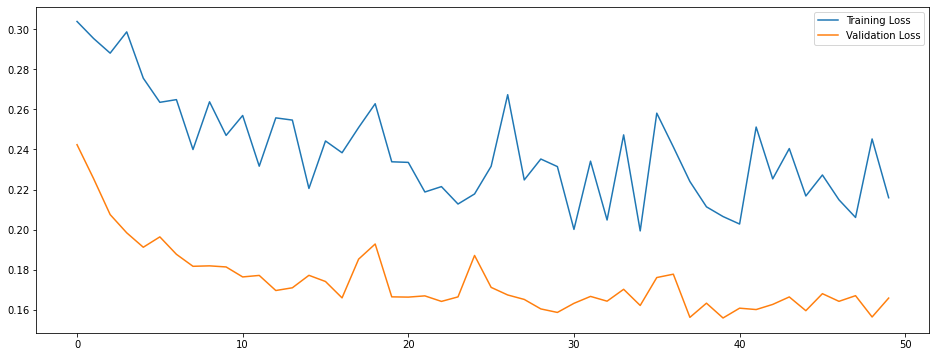

In [ ]:
fig = plt.figure(figsize=(16,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
leg = plt.legend()



In [ ]:
config_best_traj=preproc_traj.config_optimized_traj()
best_traj_config=best_hps.values
config_best_traj['ordering']=best_traj_config['ordering']
config_best_traj['vd_spiral_arms']=best_traj_config[ 'vd_spiral_arms']
config_best_traj['vd_inner_cutoff']=best_traj_config['vdi']
config_best_traj['pre_vd_outer_cutoff']=best_traj_config['pre_vdo']
config_best_traj['vd_outer_density']=best_traj_config['outer_den']
config_best_traj['vd_type']=best_traj_config['vd_type']

traj_function=preproc_traj.create_traj_fn(**config_best_traj)
preproc_function=preproc_fastdvdnet.preprocessing_fn(**config_preproc)

In [ ]:
#Save Configuration
import json
global_config={**config,**config_best_traj,**config_preproc,**config_model}
for key in global_config.keys():
    global_config[key]=str(global_config[key])
filename = os.path.join(exp_dir,'config.json')
with open(filename, 'w') as f:
    f.write(json.dumps(global_config))


{'ordering': 'linear', 'vd_spiral_arms': 21, 'vdi': 0.37020291267180283, 'pre_vdo': 0.3371587993577936, 'outer_den': 0.1409644650670577, 'vd_type': 'quadratic', 'tuner/epochs': 5, 'tuner/initial_epoch': 2, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0004'}


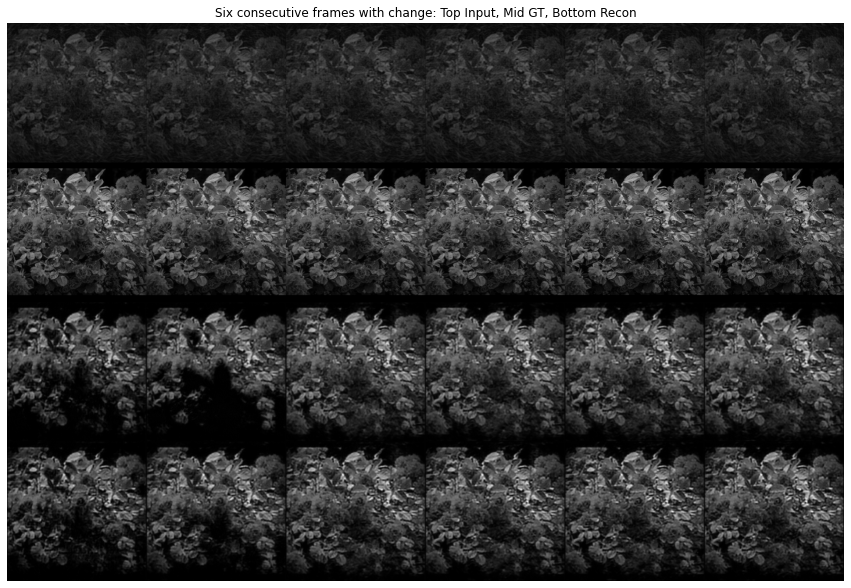

In [ ]:
#Inference
#Preproc series 1
print(best_hps.values)
model = tuner.hypermodel.build(best_hps)
model.load_weights(checkpoint_filepath)
kspace=preproc_natural_image(val_files[1])
ds=tf.data.Dataset.from_tensors(kspace)
image=traj_function(ds)
for element in image:
  inputs_temp,gt_temp=preproc_function(element)
#Preproc series 2
kspace2=preproc_natural_image(val_files[2])
ds2=tf.data.Dataset.from_tensors(kspace2)
image2=traj_function(ds2)
for element in image2:
  inputs_temp2,gt_temp2=preproc_function(element)

#Run model on buffered 5 image in a series
inputs=np.concatenate((inputs_temp,inputs_temp2),axis=2)
gts=np.concatenate((gt_temp,gt_temp2),axis=2)
buffer=[]
output=[]
bestoutput=[]
for pp in range(inputs.shape[-1]):
  buffer.append(inputs[:,:,pp])
  if pp>3:
    model_input=np.expand_dims(np.stack(buffer,axis=-1),axis=0)
    output.append(model(model_input))
    bestoutput.append(best_model(model_input))
    buffer=buffer[1:]

output=np.concatenate(output,axis=-1)
bestoutput=np.concatenate(bestoutput,axis=-1)
plot_image=np.concatenate((inputs[:,:,4:],gts[:,:,4:],output[0,...],bestoutput[0,...]),axis=0)

plt.figure(figsize=(15,12))
start_frame=10
plt.imshow(np.abs(np.concatenate((plot_image[:,:,start_frame],plot_image[:,:,start_frame+1],plot_image[:,:,start_frame+2],plot_image[:,:,start_frame+3],plot_image[:,:,start_frame+4],plot_image[:,:,start_frame+5]),axis=1)),cmap='gray')
plt.axis('off')
plt.title('Six consecutive frames with change: Top Input, Mid GT, Bottom Recon')
savefilename=os.path.join(exp_dir,'fig_orientation_change')
plt.savefig(savefilename)

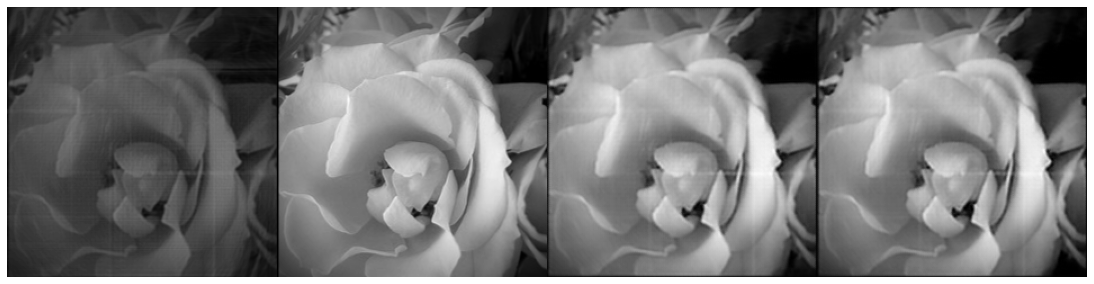

In [ ]:
#From Left to Right: Input, Ground Truth, Reconstructed.
savepath=os.path.join(exp_dir,'video_orientation_change')
display_func.plotVid(np.transpose(plot_image,axes=[1,0,2]),interval=55,vmin=0,vmax=1,savepath=savepath)